# Penalized likelihood and soft thresholding

## Part A

## Part B

### 1. generate sparse vector theta

In [ ]:
# sparse vector theta
set.seed(100)
theta.origin = rnorm(100, 100, 10)
sparse = 0.5  # sparsity of theta
mask = rbinom(100, 1, sparse)
theta = matrix(theta.origin * mask, nrow = 100)
# sigma
sigma2 = matrix(1, nrow=100)

### 2. simulate data point

In [233]:
z = matrix(0, nrow=100)
for (i in 1:nrow(theta)) {
    zi = rnorm(1, theta[i,1], sigma2[i,1])
    z[i,1] = zi
}

### 3. Compute theta_hat

In [234]:
# soft thresholding function
s_fn <- function(y, lambda) {
    sign(y)*max(abs(y)-lambda, 0)
}

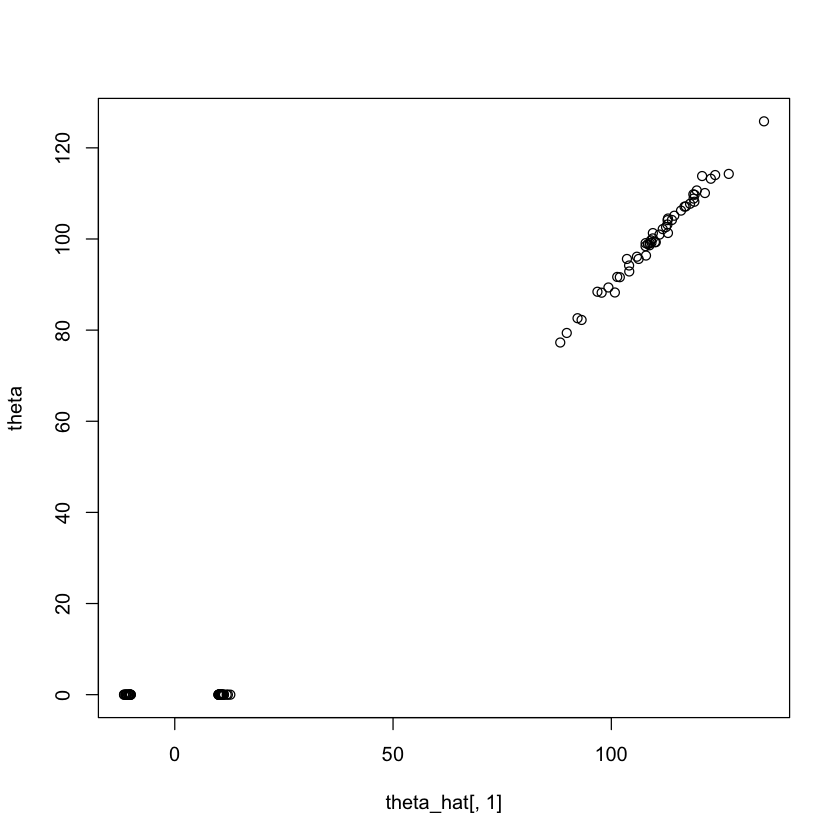

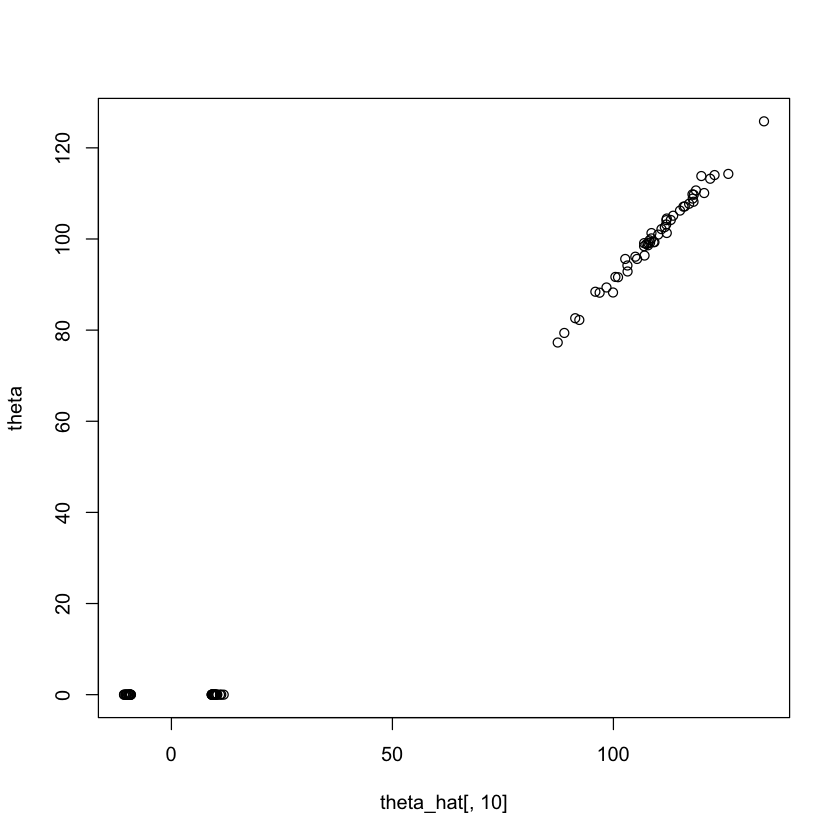

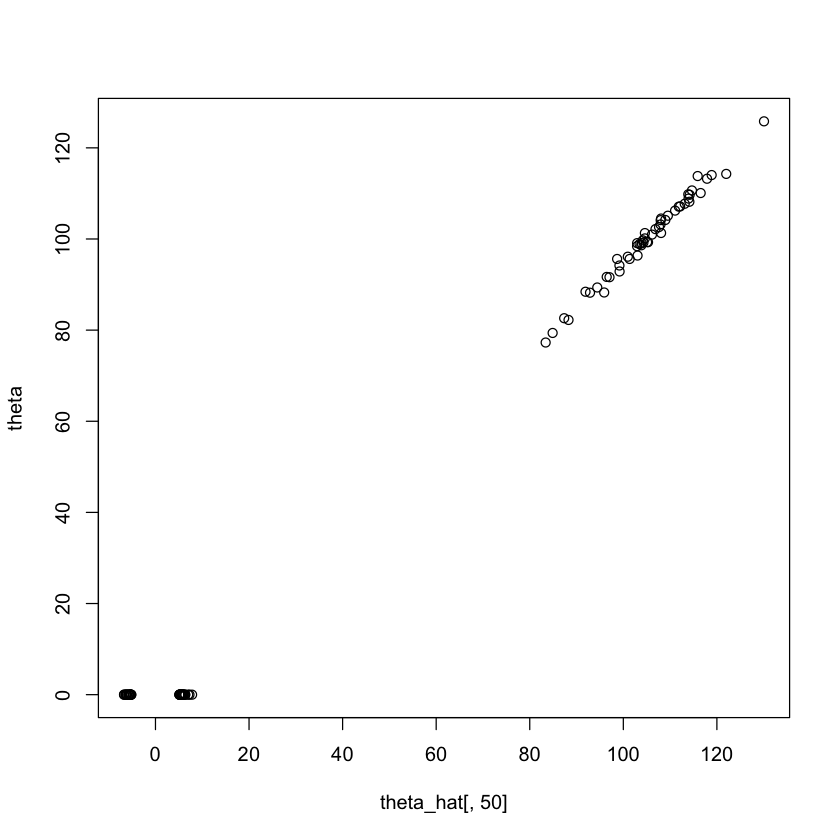

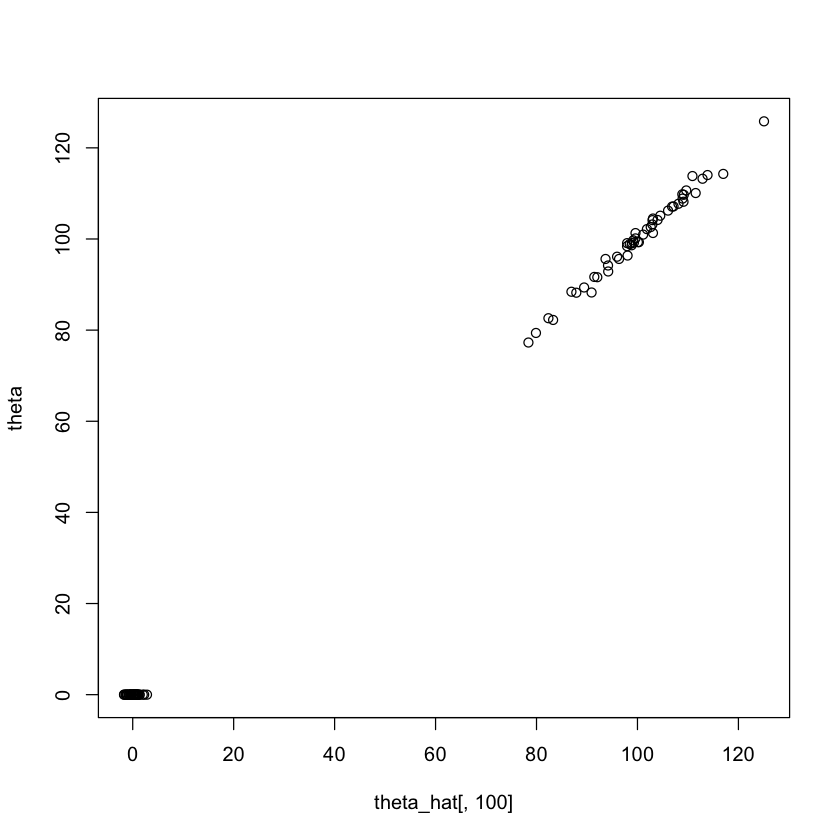

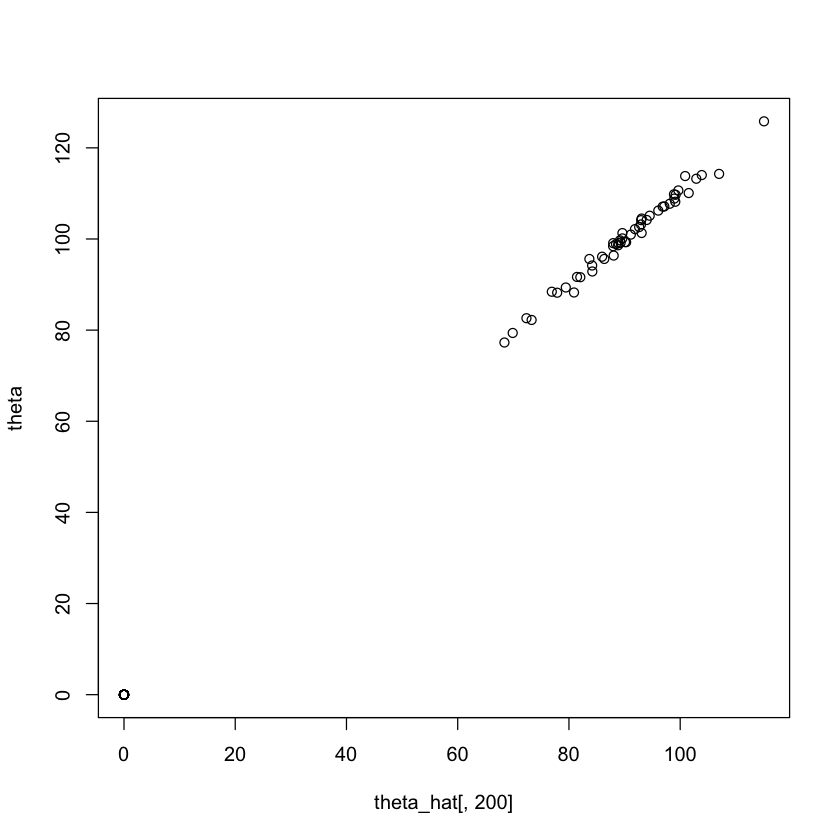

In [235]:
theta_hat = matrix(0, nrow=100, ncol=201)

# try different thetas 
lambda = seq(-10,10, 0.1)  # 201 lambdas
for (i in 1:length(lambda)) {
    for (j in 1:nrow(z)) {
        theta_hati = s_fn(z[j,1], lambda=lambda[i])
        theta_hat[j,i] = theta_hati
    }
}

plot(theta_hat[,1], theta)
plot(theta_hat[,10], theta)
plot(theta_hat[,50], theta)
plot(theta_hat[,100], theta)
plot(theta_hat[,200], theta)

### 4. Plot MSE

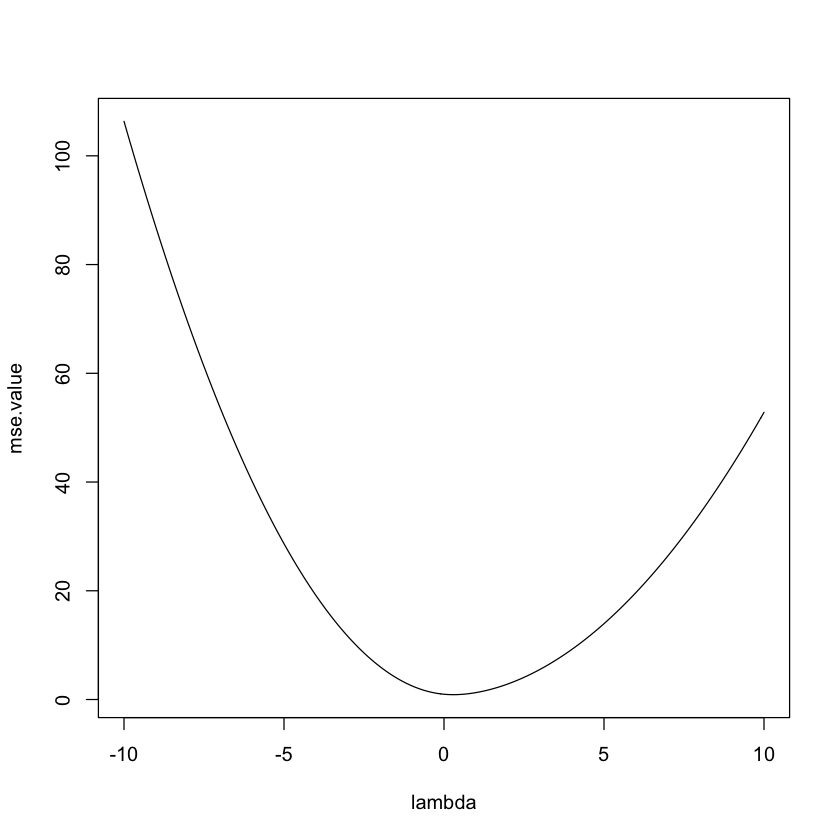

In [236]:
mse <- function(theta_hat, theta) {
    1/length(theta) * t(theta_hat - theta) %*% (theta_hat - theta)
}

mse.value = matrix(0, ncol=length(lambda))
for (i in 1:ncol(theta_hat)) {
    value = mse(theta_hat[,i], theta)
    mse.value[1, i] = value
}

plot(lambda, mse.value, type='l')

# The lasso

### Part A

In [140]:
# read data
setwd("~/Box Sync/PhDCourses/SDS385Statistical_models_for_big_data/SDS385/data/")
x = read.csv('diabetesX.csv')
x = as.matrix(x)
y = read.csv('diabetesY.csv', header=F)
y = as.vector(t(y))

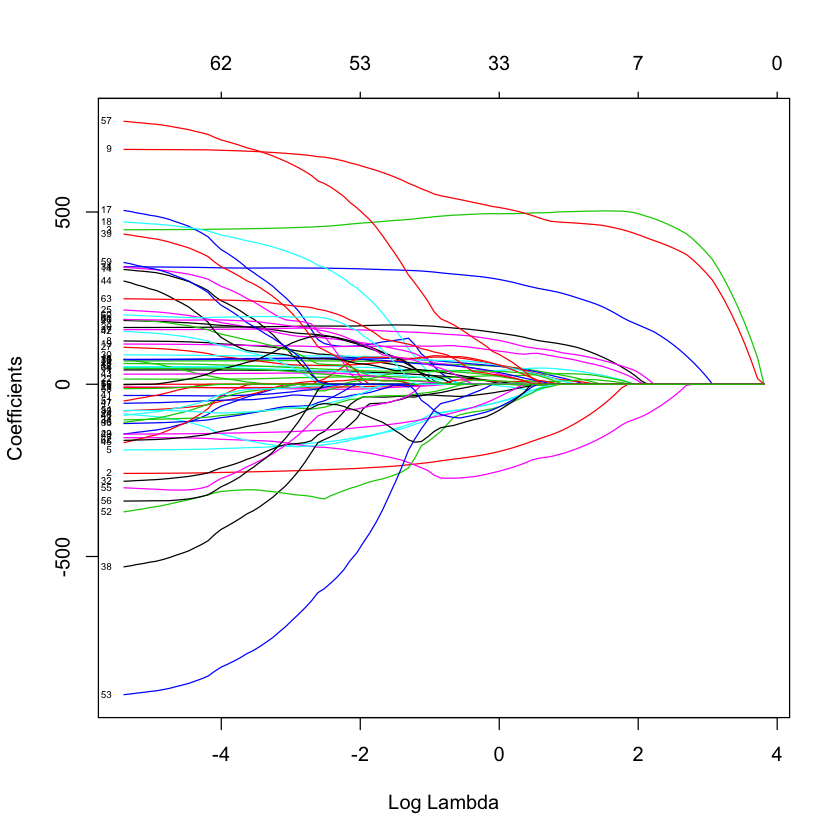

In [141]:
# fit lasso
library('glmnet')
fit.a = glmnet(as.matrix(x), y)
plot(fit.a, xvar = "lambda", label = TRUE)

In [142]:
# tracking in-sample MSE
lambdas.a = fit.a$lambda
predictions.a = predict(fit.a, newx = x, type = "response", s = lambdas.a)

# calculate MSE
MSE.a <- matrix(0, ncol=length(lambdas.a))
for (i in 1:length(lambdas.a)) {
    MSE.a[i] <- 1/dim(x)[1] * t(as.matrix(y - predictions.a[, i])) %*% as.matrix(y - predictions.a[, i])
}

In [143]:
lambda.min.a = lambdas.a[which(MSE.a == min(MSE.a))]
print (paste("lambda.min is", lambda.min.a))
print (paste("MSE min is", min(MSE.a)))

[1] "lambda.min is 0.0045160030020463"
[1] "MSE min is 2432.37739860568"


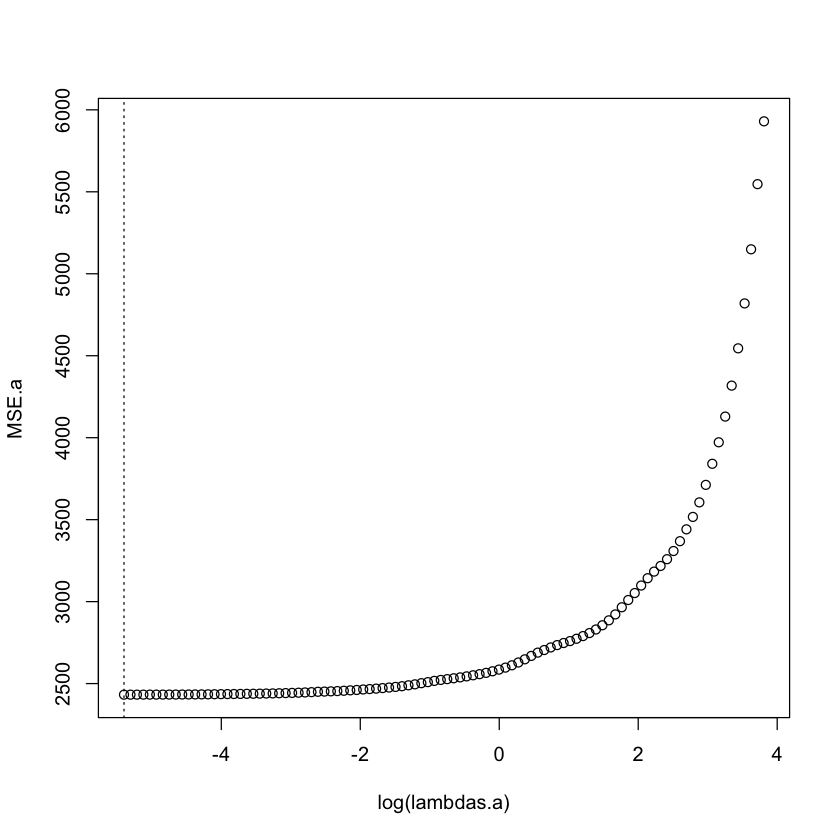

In [144]:
# plot lambda vs im-sample MSE
plot(log(lambdas.a), MSE.a)
abline(v=log(lambda.min.a), lty = 3)

### Part B

`cut` function can be used for cv.

In [145]:
# crossing validation function
cross_val <- function(x, nfolds=10) {
    # input x should be a data frame
    nfolds.list = list()
    n = nrow(x) %/% nfolds
    remainder = nrow(x) %% nfolds
    if (remainder != 0) {
        x$index = sample(c(rep(1:nfolds, n), 1:remainder))
    } else {
        x$index = sample(rep(1:nfolds, n))
    }
    for (i in 1:nfolds) {
        nfolds.list[[i]] = which(x$index == i)
    }
    return (nfolds.list)   
}

In [146]:
nfolds = 10
lambdas.b = lambdas.a
index <- cross_val(as.data.frame(x), nfolds=nfolds)
MSE.b <- matrix(0, nrow = nfolds, ncol=length(lambdas.b))

for (i in 1:nfolds) {
    if (nfolds != 1) {
        test.index = index[[i]]
        x.test = x[test.index, ]
        x.train = x[-test.index, ]
        y.test = y[test.index]
        y.train = y[-test.index]
    } else {
        x.train = x
        x.test = x
        y.train = y
        y.test = y
    }
    # train model
    fit.b = glmnet(x.train, y.train, lambda = lambdas.b)
    lambdas.b = fit.b$lambda
    # prediction
    predictions.b = predict(fit.b, newx = x.test, type = "response", s = lambdas.b)
    for (j in 1:length(lambdas.b)) {
        MSE.b[i,j] <- t(as.matrix(y.test - predictions.b[, j])) %*% as.matrix(y.test - predictions.b[, j])
    }
    MSE.mean.b = colSums(MSE.b)/dim(x)[1]
}


In [147]:
lambda.min.b = lambdas.b[which(MSE.mean.b == min(MSE.mean.b))]
print (paste("lambda.min is", lambda.min.b))
print (paste("MSE min is", min(MSE.mean.b)))

[1] "lambda.min is 3.04114445866347"
[1] "MSE min is 2982.38041473944"


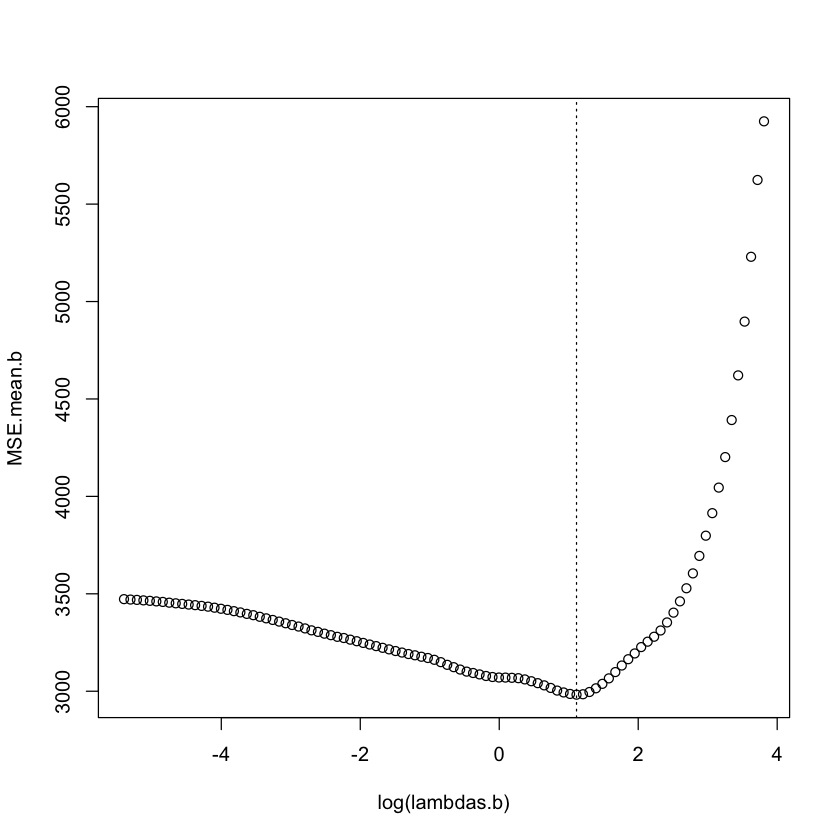

In [148]:
plot(log(lambdas.b), MSE.mean.b)
abline(v=log(lambda.min.b), lty=3)

### Part C

In [149]:
# unbiased estimate of sigma^2 from OLS solution
formula <- as.formula(paste("y ~ ", paste(colnames(x), collapse='+')))
data <- cbind(as.data.frame(y), as.data.frame(x))
fit.ols = lm(formula, data)

In [150]:
prediction.ols = predict(fit.ols, newx = x, se.fit=TRUE, type = 'response')
# calculate the residual variance
sigma2 = (prediction.ols$residual.scale)^2

In [151]:
# calculate Cp statistic
Cp = MSE.a + 2 * fit.a$df/dim(x)[1] * sigma2

In [152]:
lambda.min.c = lambdas.a[which(Cp == min(Cp))]
print (paste("lambda.min is", lambda.min.c))
print (paste("Cp min is", min(Cp)))

[1] "lambda.min is 2.52481155680962"
[1] "Cp min is 2939.8312535469"


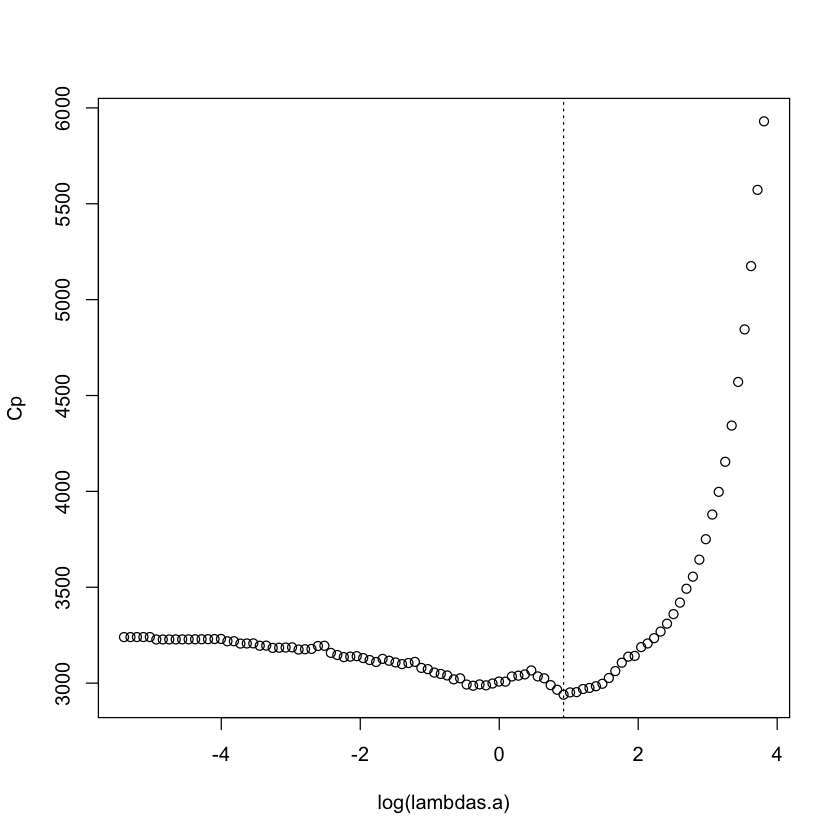

In [153]:
plot(log(lambdas.a), Cp)
abline(v=log(lambda.min.c), lty=3)

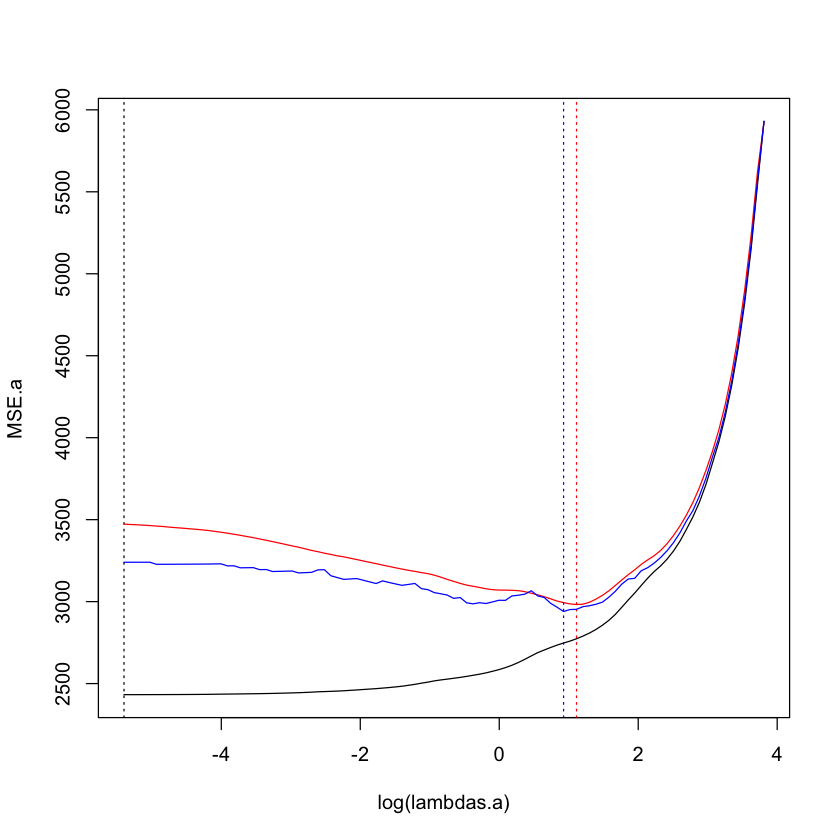

In [154]:
# Compare
plot(log(lambdas.a), MSE.a, type='l')
abline(v=log(lambda.min.a), lty = 3)
lines(log(lambdas.b), MSE.mean.b, col='red')
abline(v=log(lambda.min.b), lty=3, col='red')
lines(log(lambdas.a), Cp, col='blue')
abline(v=log(lambda.min.c), lty=3, col='blue')